# Create instances of Data from log-normal mocks

In [1]:
import time

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import generate_mock, split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func_utils import *

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog_dat = catalog_data.Data.load(data_dir+catalog_name+'.npy')

cellsize = 10
resampler = 'tsc'

# Compute density with weights
catalog = density_split.DensitySplit(catalog_dat)
catalog.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=True, use_weights=True)

[000001.43] [0/1] 06-19 18:26  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2934922.
[000002.17] [0/1] 06-19 18:26  CatalogMesh               INFO     Painted 2934922 out of 2934922 objects to mesh.


## Mock properties

In [4]:
nmesh = 100
boxsize = catalog.boxsize
boxcenter = catalog.boxcenter
seed = 42
los = 'x'
nbar = catalog.data.size/catalog.boxsize**3

z = catalog.data.redshift

# Abacus summit cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

f = bg.growth_rate(z)
bias = 1.8

pklin = cosmo_abacus.get_fourier().pk_interpolator().to_1d(z)

In [5]:
f

array(0.89781353)

In [6]:
bg.Omega_m(z)**0.55

0.8997766233678598

## Abacus summit cosmology

In [7]:
# unitary_amplitude forces amplitude to 1
mock = LagrangianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=False)

# this is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias - 1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
data = mock.to_catalog()

[000003.13] [0/1] 06-19 18:26  LagrangianLinearMock      INFO     White noise generated.
[000003.31] [0/1] 06-19 18:26  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 2939358.
[000003.38] [0/1] 06-19 18:26  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.


In [8]:
# Create Data instance
positions = data['Position'].T % boxsize

# Set rsd
mock.set_rsd(f=f, los=los)
data_rsd = mock.to_catalog()
positions_rsd = data_rsd['Position'].T % boxsize

mock_catalog = catalog_data.Data(positions, z, boxsize, boxcenter, name='mock')
mock_catalog.set_rsd(positions_rsd=positions_rsd)

In [13]:
positions

array([[506.88832261 498.5037279  503.76126128 ... 496.55127636 496.58318008
  486.79772513]
 [498.76157452 497.89565447 499.00437744 ... 495.77709948 492.73392051
  490.38011594]
 [505.74812192 507.26445994 502.23271942 ... 494.62035345 493.97310056
  495.41539007]])

In [14]:
data['Position'].T % boxsize

array([[505.80930546 497.10386392 502.42921304 ... 493.85964928 493.91001702
  483.32232698]
 [498.76157452 497.89565447 499.00437744 ... 495.77709948 492.73392051
  490.38011594]
 [505.74812192 507.26445994 502.23271942 ... 494.62035345 493.97310056
  495.41539007]])

In [15]:
data_rsd['Position'].T % boxsize

array([[505.80930546 497.10386392 502.42921304 ... 493.85964928 493.91001702
  483.32232698]
 [498.76157452 497.89565447 499.00437744 ... 495.77709948 492.73392051
  490.38011594]
 [505.74812192 507.26445994 502.23271942 ... 494.62035345 493.97310056
  495.41539007]])

## Compute density

In [9]:
cellsize = 10
resampler = 'tsc'

# Compute density without weights
mock_density = density_split.DensitySplit(mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=True, use_weights=False)

[000005.76] [0/1] 05-23 17:13  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2939358.
[000006.54] [0/1] 05-23 17:13  CatalogMesh               INFO     Painted 2939358 out of 2939358 objects to mesh.


### Plot density distribution

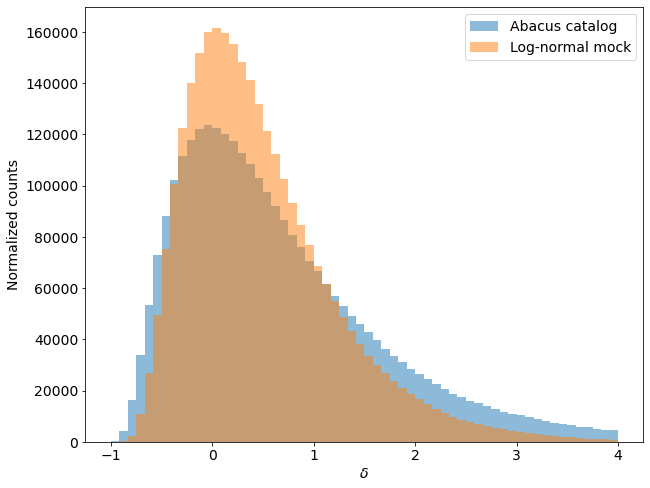

In [10]:
plt.hist(catalog.data_densities, range=(-1, 4), bins=60, density=False, alpha=0.5, label='Abacus catalog')
plt.hist(mock_density.data_densities, range=(-1, 4), bins=60, density=False, alpha=0.5, label='Log-normal mock')
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.legend()
plt.show()

## Compute 2PCF

In [11]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))
los = 'x'

In [12]:
result = TwoPointCorrelationFunction('smu', edges,
                                     data_positions1=mock_catalog.positions_rsd,
                                     boxsize=mock_catalog.boxsize,
                                     engine='corrfunc', nthreads=128,
                                     los = los)

[000007.09] [0/1] 05-23 17:13  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000007.09] [0/1] 05-23 17:13  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000044.86] [0/1] 05-23 17:14  TwoPointCorrelationFunction INFO     Analytically computing two-point counts R1R2.


## Compare mock 2PCF with data

In [13]:
ells = [0, 2]
nells = len(ells)

In [14]:
abacus_results = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z1.175_2PCF_RSD.npy')

[000044.87] [0/1] 05-23 17:14  TwoPointEstimator         INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z1.175_2PCF_RSD.npy.


In [15]:
s, abacus_xiell = abacus_results.get_corr(ells=ells, return_sep=True)
mocks_xiell = result.get_corr(ells=ells, return_sep=False)

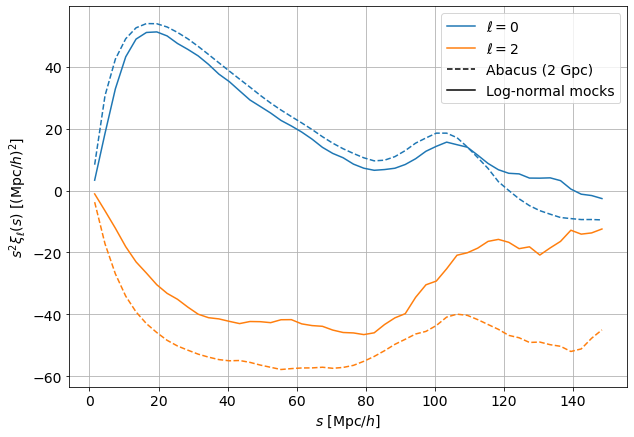

In [16]:
plt.rcParams["figure.figsize"] = (10, 7)

for ill, ell in enumerate(ells):
    plt.plot(s, s**2 * abacus_xiell[ill], linestyle = '--', color='C'+str(ill))
    plt.plot(s, s**2 * mocks_xiell[ill])
    # for legend
    plt.plot([],[], linestyle='-', color='C'+str(ill), label='$\ell = {:d}$'.format(ell))
    plt.grid(True)

plt.plot([],[], linestyle='--', color='black', label='Abacus (2 Gpc)')
plt.plot([],[], linestyle='-', color='black', label='Log-normal mocks')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.legend()
plt.show()